In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

This notebook is an exploration in strategies for scaling neural nets training for large models across multiple devices. The intention is educational - we'll build all the required elements from the ground up and understand exactly where each computation is going. For production ready code, look at the Deepspeed library (for Pytorch), or GPT-J (Jax). 

We'll start off by looking at the basic types of parallelism, then implement a transformer which uses the megatron-LM data+tensor parallelism scheme. In a future, we'll look at pipeline parallelism, implement ZeRO style sharding - and use Ray to coordinate a K8s cluster of TPUv2s (for all those times you don't have a TPUvX-256!)


This notebook should be run on a TPU (either through GCP / TRC or Colab) as that gives us 8 devices to experiment with. In general, TPUs make training large models much easier - as your needs scale you can use bigger and bigger TPU pods, so its easy to see why Tesla is making their own extensible hardware mesh in Dojo. 

A couple of resources that I've leant on:

- [Lilian Weng's superb notes on training large models](https://lilianweng.github.io/lil-log/2021/09/24/train-large-neural-networks.html)
- [Ben Wang's GPT-J](https://github.com/kingoflolz/mesh-transformer-jax)
- [Karpathy's MinGPT](https://github.com/karpathy/minGPT)

Note: The memory profiling won't work on colab TPUs as they are running an older version of relevant software.

In [1]:
colab = False # set True if on a colab TPU
if colab == True:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()

In [1]:
from jax import random
import jax
import jax.numpy as jnp
import jax.profiler
from jax import pmap,value_and_grad
from PIL import Image
import os

# Let jax de-allocate memory when the object is no longer necessary, slows things down - but keeps our memory profiles more accurate if you
# are playing with this notebook rather than progressing straight through. 
# If you don't set this, memory profiling will be inaccurate when looking at the transformer blocks due to previous allocations. 
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'


In [2]:
# Two helper functions which allow us to visualise memory usage

def show_call_graph():
    !go tool pprof -png memory.prof
    img = Image.open('profile001.png')
    os.remove('profile001.png')
    return img

def show_mem(result):
    result.block_until_ready()
    jax.profiler.save_device_memory_profile("memory.prof")
    !go tool pprof -tags memory.prof

# Simple data parallel matrix multiplication

Lets use pmap to partition initialisation and computation across each TPU node!

In [3]:
x_devices = 8

batch = 2048
embed = 4096
w_hidden = 8192

keys = random.split(random.PRNGKey(0), x_devices) # [2,x_devices]

def matmult(inp,w1):
    # run a local matmul on each device in parallel (no data transfer)
    result = pmap(jnp.matmul)(inp,w1)
    print(result.shape)
    show_mem(result)

Create the weights matrix sharded across each device with pmap - notice that memory consumption is equal.

In [4]:
inp = pmap(lambda key: random.normal(key, (batch, embed), dtype=jnp.float32))(keys) # [x_devices, batch, embed]
w1  = pmap(lambda key: random.normal(key, (embed, w_hidden), dtype=jnp.float32))(keys) # [w_hidden, embed]

matmult(inp, w1)

(8, 2048, 8192)

 device: Total 1.8GB
         224.0MB (12.50%): TPU_0(process=0,(0,0,0,0))
         224.0MB (12.50%): TPU_1(process=0,(0,0,0,1))
         224.0MB (12.50%): TPU_2(process=0,(1,0,0,0))
         224.0MB (12.50%): TPU_3(process=0,(1,0,0,1))
         224.0MB (12.50%): TPU_4(process=0,(0,1,0,0))
         224.0MB (12.50%): TPU_5(process=0,(0,1,0,1))
         224.0MB (12.50%): TPU_6(process=0,(1,1,0,0))
         224.0MB (12.50%): TPU_7(process=0,(1,1,0,1))

 kind: Total 1.8GB
         1.8GB (  100%): buffer
       -9.0B (4.8e-07%): executable



Create an [8,X,X] matrix and distribute it across each device - notice that memory consumption is concentrated on devices[0] because that is where it was implicitly created - despite the fact that the computation is distributed. This underscores the need for both distributed init and compute operations later on. 

In [5]:
inp = pmap(lambda key: random.normal(key, (batch, embed), dtype=jnp.float32))(keys) # [x_devices, batch, embed]
w1_dist  = random.normal(random.PRNGKey(0), (x_devices, embed, w_hidden), dtype=jnp.float32) # [w_hidden, embed]


matmult(inp, w1_dist)

del w1_dist # gc this so that it doesn't clog up memory if the cell is re-run

(8, 2048, 8192)

 device: Total 2.8GB
           1.2GB (44.32%): TPU_0(process=0,(0,0,0,0))
         224.0MB ( 7.95%): TPU_1(process=0,(0,0,0,1))
         224.0MB ( 7.95%): TPU_2(process=0,(1,0,0,0))
         224.0MB ( 7.95%): TPU_3(process=0,(1,0,0,1))
         224.0MB ( 7.95%): TPU_4(process=0,(0,1,0,0))
         224.0MB ( 7.95%): TPU_5(process=0,(0,1,0,1))
         224.0MB ( 7.95%): TPU_6(process=0,(1,1,0,0))
         224.0MB ( 7.95%): TPU_7(process=0,(1,1,0,1))

 kind: Total 2.8GB
          2.8GB (  100%): buffer
       -11.0B (3.7e-07%): executable



# Tensor parallelism

What if we have a layer or model that is too big to fit on a single device? 

The great thing about TPUs is that they are a hardware _mesh_ - and when we use xmap we can use named axis to re-arrange these at will to achieve both data and model parallelism.

How does model parallelism work? For starters, lets look at [Megatron LM's method](https://arxiv.org/pdf/1909.08053.pdf), which is what was used for GPT-J. It has a great balance of simplicity and effectiveness, and is very efficient provided you have a hardware mesh. Luckily we do!

- Megatron LM: Takes advantage of the fact that  matrix multiplication and self-attention can be calculated across separate devices with minimal communication. Megatron's approach optimises for minimising communication overheads at the expense of some increase in memory. E.g., the layer norm parameters are duplicated, and take the output of the previous layer. "Since all parameters are either local or duplicated, there is no need for communicating updated parameters."

How does it work in the case of a simple matrix multiplication + nonlinearity?

$$ Y  = GELU(XA) $$ 

If we split A along it's columns A = [A_1, A_2], we can perform the calculation and apply the non-linearity indepedently.

$$ Y  = [Y_1, Y_2] = [GeLU(XA_1), GeLU(XA_2)]$$

In the next section we'll look at how it works with multiple MMs and self-attention, first lets introduce x-map and distribute a computation with it. Note - <b> as in the second example above because we are not distributing the creation of the inputs and weights matrices the memory will be concentrated on the first device <b>. In the next section we'll look at how to use xmap to also distribute the initialisation.




In [6]:
from jax.experimental.maps import mesh, xmap
import numpy as np
batch = 2048
embed = 4096
w_hidden = 16384

inp = random.normal(random.PRNGKey(0), (batch, embed), dtype=jnp.float32) # [batch, embed]
w1  = random.normal(random.PRNGKey(0), (w_hidden, embed), dtype=jnp.float32) # [w_hidden, embed]

In [7]:
# reshape our 8 devices into a 4,2 mesh with axis names x,y
x_devices = 4
y_devices = 8//x_devices

axis_names = ('x', 'y')
mesh_devices = np.array(jax.devices()).reshape((x_devices, y_devices))
mesh_def = (mesh_devices, axis_names)

In [8]:
def matmult(x, w1):
    '''
    x: [x_devices: the number of devices we are partitioning across
        batch: ..
        embed: .. ]
    w1: [w_hidden: will be partioned evenly over the columns of the mesh 
         embed: the hidden size, but it is partitioned ... ]
    '''

    res = jnp.matmul(x,w1)
    mean_embed = jnp.sum(res, axis=['batch']) / 8096
    return mean_embed

with mesh(*mesh_def):
    out = xmap(matmult, 
              in_axes = (['batch',  ...], ['w_hidden', ...]),
              out_axes = ['batch', 'w_hidden', ...],
              axis_resources={'batch': 'x', 'w_hidden': 'y'})(inp, w1)
    
    
    show_mem(out)
    print(out.shape)
    
del out, w1, inp

/usr/local/lib/python3.8/dist-packages/jax/experimental/maps.py:418: UserWarning: xmap is an experimental feature and probably has bugs!
  warn("xmap is an experimental feature and probably has bugs!")


Main binary filename not available.
 device: Total 416.0MB
         304.0MB (73.08%): TPU_0(process=0,(0,0,0,0))
          16.0MB ( 3.85%): TPU_1(process=0,(0,0,0,1))
          16.0MB ( 3.85%): TPU_2(process=0,(1,0,0,0))
          16.0MB ( 3.85%): TPU_3(process=0,(1,0,0,1))
          16.0MB ( 3.85%): TPU_4(process=0,(0,1,0,0))
          16.0MB ( 3.85%): TPU_5(process=0,(0,1,0,1))
          16.0MB ( 3.85%): TPU_6(process=0,(1,1,0,0))
          16.0MB ( 3.85%): TPU_7(process=0,(1,1,0,1))

 kind: Total 416.0MB
        416.0MB (  100%): buffer
       -16.0B (3.7e-06%): executable

(2048, 16384)


This is really cool! With x-map, we can just take the same size inputs [2048, 4096] and [4096, 16384], and perform the computation in both a data and batch parallel fashion. The batch axis is split across 4 machines, the weight across 2 - and it comes back whole. 

# A transformer block

- Ben Wang's GPT-J has an excellent, production ready example. Here, we'll draw from the design choices of both minGPT and GPT-J in an effort to make a minimal, but complete example. 
- The key fact that we're taking advantage of is that sections of the embedding are allocated to differnet self-attention 'heads' - which means that we can split across as long as the the # heads is divisible by the number of shards. E.g. if our embedding is 2048, and we have 8 heads of 256 each - we could split the embedding across 2 shards, alllocating 4 heads per shard. See the following diagram from the megatron-LM paper


In [9]:
import haiku as hk


GPT1Config = {
    'n_vocab': 5000,
    'block_size': 32,
    'n_layer' : 12,
    'n_head' : 12,
    'd_model' : 768,
    'shards': 2}


class TransformerLayerShard(hk.Module):
        '''
        # A simple transformer layer shard that exists on one of the devices. 
        '''
        def __init__(self, config, name=None, init_scale=1.):
            super().__init__(name=name)
            heads = config["n_head"]
            dim = config["d_model"]
            self.shards  = config["shards"]
            
            assert dim % heads == 0 
            assert heads % self.shards == 0 
            
            self.dim_per_head = dim // heads
            self.dim_per_shard = dim // self.shards
            self.heads_per_shard = heads // self.shards
            
            # GPT-J uses a common layer norm between the mlp and the self attention, minGPT uses different layers - lets go with one for now. Much of a muchness.
            self.ln = hk.LayerNorm(-1, True, True)
            
            # key, query and value projections for all heads on this shard
            self.q = hk.Linear(self.dim_per_shard, with_bias=False)
            self.k = hk.Linear(self.dim_per_shard, with_bias=False)
            self.v = hk.Linear(self.dim_per_shard, with_bias=False)
            
            # self att output projection
            self.att_proj = hk.Linear(dim, with_bias=False, w_init=hk.initializers.TruncatedNormal(stddev=init_scale / np.sqrt(dim)))
            
            # feedforward layers
            self.dense_proj = hk.Linear(self.dim_per_shard * 4)
            self.dense_proj_out = hk.Linear(dim,
                                      w_init=hk.initializers.TruncatedNormal(stddev=init_scale / np.sqrt(dim)))
            
            
        def self_attention(self, q, k ,v, bias):
            '''
            k,q,v: [T, heads_per_shard, dim_per_head]
            '''
            T, _, _ = k.shape
            
            # No batch dimension needed in the einsum because it is abstracted away by the xmap 
            attention_logits = jnp.einsum('thd,Thd->htT', q, k) # [heads_per_shard, T,T]
            sqrt_key_size = np.sqrt(self.dim_per_head).astype(k.dtype) # [1,]
            
            attention_logits = attention_logits/sqrt_key_size # [heads_per_shard, T,T]
            
            attention_logits += bias # [B, heads_per_shard, T,T]
            
            attention_weights = jax.nn.softmax(attention_logits)  # [heads_per_shard, T,T]
            
            weighted_values = jnp.einsum('htT, Thd->thd', attention_weights, v).reshape((T, self.dim_per_shard)) # [T, dim_per_shard]
            
            return self.att_proj(weighted_values)
        
        def feed_forward(self, x):
            '''
            x: [T,embed_dim]
            '''
            dense_proj = self.dense_proj(x)
            dense_proj = jax.nn.gelu(dense_proj)
            return self.dense_proj_out(dense_proj)
            
            
        def qkv_proj(self, x): 
            '''
            x: [T, embed_dim]
            '''
            q = self.q(x).reshape(x.shape[:-1] + (self.heads_per_shard, self.dim_per_head)) # [T, heads_per_shard, dim_per_head]
            v = self.v(x).reshape(x.shape[:-1] + (self.heads_per_shard, self.dim_per_head)) # ""
            k = self.k(x).reshape(x.shape[:-1] + (self.heads_per_shard, self.dim_per_head)) # "" 
            
            return q,k,v
        
        
        def __call__(self, x):
            '''
            x: [T, embed_dim]
            '''
            # preliminaries    
#             print(x.shape)
            T,C = x.shape
            x = self.ln(x) # [T,embed_dim]
            
            # causal self attention
            q,k,v = self.qkv_proj(x)
            causal_mask = np.tril(np.ones((T,T))) # [T,T]
            bias = -1e10 * (1. - causal_mask) # [T,T]
            attn = self.self_attention(q, k ,v, bias)  # [T,embed_dim]
            
            # feedforward
            ff  = self.feed_forward(x) # [B,T,embed_dim]
            
            # block
            x = x + attn # [T,embed_dim]
            x = x + ff # [T,embed_dim]
            
            # We finally need to sum across shards to collect the information from each head into the new embedding. 
            # The idea of heads 'adding to the information stream' is a nice way of thinking about transformers from Anthropic's 
            # latest work. 
            # In the full GPT-J implementation, they've defined a custom operator which does the psum on the forward pass but
            # is the identity function on the backward pass - currently testing how necessary that is.
            return jax.lax.psum(x, "shard")

        
                
def model_fn(x):
    model = TransformerLayerShard(GPT1Config)
    return model(x)


In [10]:
# It would be possible to test the above block without xmap if we got rid of the psum - but I'm going to be slightly opinionated here despite the boilerplate setup.
batch = 4
shard = 2

axis_names = ('dp', 'mp')
mesh_devices = np.array(jax.devices()).reshape((batch, shard))
mesh_def = (mesh_devices, axis_names)


init = jax.experimental.maps.xmap(fun=hk.transform(model_fn).init,
                                  in_axes=(["shard", ...],
                                           ["batch", ...]),
                                  out_axes=["shard", ...],
                                  axis_resources={'shard': 'mp', 'batch': 'dp'})

forward = jax.experimental.maps.xmap(fun=hk.without_apply_rng(hk.transform(model_fn)).apply,
                                     in_axes=(["shard", ...],
                                              ["batch", ...]),
                                     out_axes=["batch", ...],
                                     axis_resources={'shard': 'mp', 'batch': 'dp'})

In [11]:
key = hk.PRNGSequence(42)
x = jax.random.uniform(next(key), (16, 32, 768), minval=0, maxval=255).astype(jnp.float32)  # [B,T,embed]

with jax.experimental.maps.mesh(*mesh_def):
    state = init(jnp.array(key.take(shard)), x)

    o = forward(state, x)
    show_mem(o)
    print(o.shape)

Main binary filename not available.
 device: Total 112.7MB
         15.4MB (13.66%): TPU_0(process=0,(0,0,0,0))
         13.9MB (12.33%): TPU_1(process=0,(0,0,0,1))
         13.9MB (12.33%): TPU_2(process=0,(1,0,0,0))
         13.9MB (12.33%): TPU_3(process=0,(1,0,0,1))
         13.9MB (12.33%): TPU_4(process=0,(0,1,0,0))
         13.9MB (12.33%): TPU_5(process=0,(0,1,0,1))
         13.9MB (12.33%): TPU_6(process=0,(1,1,0,0))
         13.9MB (12.33%): TPU_7(process=0,(1,1,0,1))

 kind: Total 112.7MB
        112.7MB (  100%): buffer
       -23.0B (1.9e-05%): executable

(16, 32, 768)


# Creating a transformer

Now all we're missing is an embedding layer to transform a sequence of discrete tokens to a dense vector - and an output projection layer to send it back! 


## Embedding layer
Functionally, this is a sequence of [Batch, Time, Vocab_size] multiplied by a [Vocab_size, embedding_dim] matrix to project the one hot sequence into a dense embedding. 

There are two approaches that could make sense:

1. Partition the embedding matrix along the vocabulary dimension. The implementation of this in GPT-J is cheeky:
    i. Assign a subset of token indices to each shard. E.g. if our vocab dimension is 50k, 0-25k correspond to shard 0, 25k-50k correspond to shard 1.
    ii. In the one-hot expansion of the input sequence, zero anything which lies outside this range. This means that the projection matrix on each shard only needs to be [25k,embedding_dim], but the zero-d tokens will not contribute to the embedding on that shard.
    iii. psum across the shards to get the full embedding. 
    
    
2. Alternatively, partition along the embedding dimension. In this case, the embedding matrix on each shard would be [50k, embedding_dim//shards], every token would be fully expanded into the one-hot representation and an all_gather would be required across the shards to concatenate the embedding dim of the outputs.

In both cases  <b> the embedding weights matrix will be the same size  </b> (it doesn't matter which dimension is divided by shards),  <b> but the methods differ in terms of the space allocated for the input sequence</b>. The second method requires the full input sequence be expanded to the full one-hot representation on each device, but the first method divides the size of that representation by the number of shards - saving more space. If you're token space is in characters, this doesn't matter - but some token spaces have 10s of thousands of entries. 


In [17]:
class EmbeddingShard(hk.Module):
    def __init__(self, config, name=None):
        super().__init__(name=name)
        in_dim = config["n_vocab"]
        out_dim = config["d_model"]
        shards = config["shards"]

        assert in_dim % shards == 0

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.in_dim_per_shard = in_dim // shards
        self.out_dim_per_shard = out_dim // shards

        embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
        self.positional_embeddings = hk.get_parameter('pos_embs', [config["block_size"], self.out_dim_per_shard], init=embed_init)

        # notice unlike the ff transformer layer, this linear layer has the full output dimension because we are partitioning across vocab. 
        self.proj = hk.Linear(self.out_dim, w_init=hk.initializers.TruncatedNormal(stddev=1 / np.sqrt(in_dim)))

    def __call__(self, x, dtype=jnp.bfloat16):
        
        # work out which shard we are on, and the start token index
        shard_start_index = jax.lax.axis_index('shard') * self.in_dim_per_shard
        
        # subtract the shard_start_index from the input indices. This means anything below it will be zero-d (as it will be a negative number)
        # at the same time, anything above 'in_dim_per_shard' will also be zero-d. This means that each shard gets a window of in_dim_per_shard indices
        # which it will expand to a one-hot representation - saving lots of space!
        input_onehot = jax.nn.one_hot(x - shard_start_index, self.in_dim_per_shard)
        proj_out = self.proj(input_onehot)
        # sum across shards to create a full embedding
        proj_out = jax.lax.psum(proj_out, "shard")
        # gets all of the positional embeddings as split across each shard (column wise split of positional embeddings)
        all_pos_embed = jax.lax.all_gather(self.positional_embeddings, 'shard')
        # flattens them, so now there are identical, complete positional embeddings on each device
        all_pos_embed = hk.Flatten()(jnp.transpose(all_pos_embed, (1, 0, 2)))

        proj_out += all_pos_embed[:proj_out.shape[0]] # only do the embeddings up to the length of the input sequence, to allow for variable input size

        return proj_out

## Projection layer

The projection layer is much more similar to the simple matrix multiplication example above. As we'll have the full embedding as an output of transformer layer below we partition across the output dim, then all gather to get the final output embedding in vocab space. 

Where it gets trickier is how this interacts with the loss calculation. The [batch, time, vocab_size] matrix output above is large, and we'd prefer to only generate it when necesary (e.g. during inference). During training, could we calculate the per shard loss components and then only cross-communicate the smaller [batch, time] cross entropy loss values?

Yes! We'll still need some cross communication (e.g. to calculate the max of the logits to stabilise it numerically, or calculate the denominator of the softmax equation), but this comes with no memory penalty!

This is directly lifted from GPT-J, but I'll comment extensively so it is clear what is going on.

The loss function isn't the typical implementation of softmax cross entropy, so lets simplify it down to explain it. The implementation is convenient and stable - minimising communication overheads across shards to a limited set of sums. If the loss function is confusing - jump to the bottom for a simplified implementation with some test inputs.



In [18]:

    
class ProjectionShard(hk.Module):
    def __init__(self, config, name=None):
        super().__init__(name=name)
        out_dim = config["n_vocab"]
        shards = config["shards"]

        assert out_dim % shards == 0

        self.dim = out_dim
        self.dim_per_shard = out_dim // shards

        self.norm = hk.LayerNorm(-1, True, True)

        self.proj = hk.Linear(self.dim_per_shard)

    def __call__(self, x):
        x = self.norm(x)
        proj = self.proj(x)

        all_proj = jax.lax.all_gather(proj, 'shard')

        return hk.Flatten()(jnp.transpose(all_proj, (1, 0, 2)))

    def loss(self, x, targets, z_loss=1):
        
        '''
        x: [T, dim_per_shard]
        targets: [T]
        '''
        x = self.norm(x)
        # calculate logits on a per shard basis
        logits = self.proj(x) # [T, dim_per_shard]
        # get the max of logits per dimension across the shards. Use this to prevent both under and overflow by subtracting it from every logit.
        # For an explaination on why you need this - see the opening pages of chapter 4 'Numerical computation' in goodfellow's deep learning book. 
        global_max = jax.lax.pmax(jax.lax.stop_gradient(logits.max(-1, keepdims=True)), "shard")
        logits -= jax.lax.stop_gradient(global_max) # [T, dim_per_shard]
        
        # As we are computing the output vocab matrix in a sharded fashion, only get the targets corresponding to that shard
        # using the same trick as used in the embedding matrix.
        shard_start_index = jax.lax.axis_index('shard') * self.dim_per_shard
        gt_onehot = jax.nn.one_hot(targets - shard_start_index, self.dim_per_shard) # [T, dim_per_shard]
        # this is a point multiplication, so it zeros out anything which isn't a 1 in the one-hot representation. 
        # then sums along the embedding axis. See above code snippet for explaination for the next few lines.
        predicted_logits = jnp.sum(jnp.multiply(gt_onehot, logits), axis=-1) # [T]
        # subtract the summed logit from the summed 'predicted_logit'
        # Any entry but the correct one is 0 in 'predicted logit' - and due to the max used for stabilisation
        # the entry of the highest index will be 0. Therefore, the subtraction of the two will draw the highest index to the correct one.
        # By only working with sums when we are using the sharded version we minimise communication.
        predicted_logits = jax.lax.psum(predicted_logits, 'shard') 
        exp_logits = jnp.exp(logits)
        sum_exp_logits = exp_logits.sum(axis=-1)
        sum_exp_logits = jax.lax.psum(sum_exp_logits, 'shard')
        loss = jnp.log(sum_exp_logits) - predicted_logits
        # An additional loss which keeps the logits small - avoiding roundoff errors in bfloat16 (according to the mesh tensorflow repo).
        loss += (1e-4 * jnp.square(jnp.log(sum_exp_logits)) * z_loss).mean()

        # Due to the above, it is easy to correctly predict accuracy. 
        correct = (0.0 == predicted_logits)
        return loss.sum(), correct
    
    


## Sharded transformer

This is easy - just combine the sharded layers as one would a transformer on one device. 

In [19]:
class CausalTransformerShard(hk.Module):
    def __init__(self, config):
        super().__init__()
        heads = config["n_head"]
        shards = config["shards"]
        layer_count = config["n_layer"]

        self.layers = []
        self.heads = heads

        self.heads_per_shard = heads // shards

        self.embed = EmbeddingShard(config)

        init_scale = 2. / layer_count

        for i in range(layer_count):
            self.layers.append(TransformerLayerShard(config, name=f"layer_{i}", init_scale=init_scale))

        self.proj = ProjectionShard(config)
        
        
    def trunk(self, tokens):
        x = self.embed(tokens)

        for l in self.layers:
            x = x + l(x)
        return x
    
    def loss(self, tokens, targets):
        x = self.trunk(tokens)
        l, acc = self.proj.loss(x, targets)
        return l

    def __call__(self, tokens):
        
        x = self.trunk(tokens)
        return self.proj(x)
    
    
    
    


# Putting it all together

The below is mostly a mix of haiku, optax and xmap boilerplate.

The new elements are:
- A dataloader: Simple, character based shakespeare. 
- An optimiser: Uses optax - carefully note where the init and update functions are (within xmap - to ensure the memory stays allocated to the correct device).
- Save/restore functions: An extremely unoptimised save/restore function. Better implementations would parallel process it, but that isn't necessary yet at TPUv2 model sizes.

In [20]:
import optax
import tensorflow as tf

GPTConfig = {
    'n_vocab': 66,
    'block_size': 32,
    'n_layer' : 3,
    'n_head' : 8,
    'd_model' : 768,
    'shards': 2,
    'devices': 4,
    'batch_size_per_parallel': 256,
    'ckpt_dir': 'test'}


# A downside of using the more memory efficient method of embedding sharding is that it requires equal shard size across devices
# or a 'check which device I'm on, lookup desired shard size'. For the moment - easier to just have equal shard size and a few empty spots for tokens.

assert GPTConfig['n_vocab'] % GPTConfig['shards'] == 0

class Dataloader():
    '''
    A super simple dataloader for a tiny dataset. Better implementations would 
    - Pre-process the data into tf-records, and stream this from 
        a GCP bucket. 
    - Eliminate unncessary copies (e.g. as_numpy_iterator)
    '''
    def __init__(self, config):
        super().__init__()
        
        if not os.path.exists('input.txt'):
            os.system('wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt')
            
        text = open('input.txt', 'r').read() 
        self.vocab = sorted(list(set(text)))
        self.vocab_len = len(self.vocab)
        self.stoi = { ch:i for i,ch in enumerate(self.vocab) }
        self.itos = { i:ch for i,ch in enumerate(self.vocab) }
        tokens = [self.stoi[c] for c in text]
        d = tf.data.Dataset.from_tensor_slices(tokens)
        d = d.batch(config['block_size']+1, drop_remainder=True) # +1 because [:-1] will be x, and [1:] will be y
        self.d = iter(d.batch(config['batch_size_per_parallel']*config['devices'], drop_remainder=True).repeat().as_numpy_iterator())
        
    def next_batch(self):
        b = self.d.next()
        return b[:, :-1], b[:, 1:] # x, y
        

In [21]:
class CausalTransformer():
    def __init__(self, config):
        super().__init__()
        
        axis_names = ('batch', 'shard')
        mesh_devices = np.array(jax.devices()).reshape((config['devices'], config['shards']))
        self.mesh_def = (mesh_devices, axis_names)

        self.config = config
        self.optimizer = optax.adam(1e-5)
        
        self.key = hk.PRNGSequence(42)
        
        self.init = jax.experimental.maps.xmap(fun=self.init_state,
                                  in_axes=(["shard", ...], # rngs
                                           ["batch", ...]), # x
                                  out_axes=["shard", ...],
                                  axis_resources={'shard': 'shard', 'batch': 'batch'})

        self.forward = jax.experimental.maps.xmap(fun=self.eval_step,
                                             in_axes=(["shard", ...], # params
                                                      ["batch", ...]), # x 
                                             out_axes=(["batch", ...]), 
                                             axis_resources={'shard': 'shard', 'batch': 'batch'})


        self.train = jax.experimental.maps.xmap(fun=self.train_step,
                                             in_axes=(["shard", ...], # state
                                                      ["batch", ...], # x
                                                      ["batch", ...]),# y
                                             out_axes=([['batch'],           # loss
                                                       ['shard',...]]), # state
                                             axis_resources={'shard': 'shard', 'batch': 'batch'})


    # Haiku pure functions for convenience 
    def eval_fn(self, x):
        model = CausalTransformerShard(self.config)
        return model(x)

    def train_fn(self, x,y):
        model = CausalTransformerShard(self.config)
        return model.loss(x,y)


    def init_state(self, key, x):
        '''
        A parallelised init function that ensures optimiser params are stored on the respective devices. 
        '''
        params = hk.transform(self.eval_fn).init(key, x)

        return {
            "params": params,
            "step": np.array(0),
            "opt_state": self.optimizer.init(params)
        }

    def eval_step(self, params, x):

        forward_fn = hk.without_apply_rng(hk.transform(self.eval_fn))
        out = forward_fn.apply(params, x)
        return out

    def train_step(self, state, x,y):

        l_fn = hk.without_apply_rng(hk.transform(self.train_fn))
        loss, grads = value_and_grad(l_fn.apply)(state['params'], x,y)
        grads = jax.lax.pmean(grads, "batch")
        updates, new_opt_state = self.optimizer.update(grads, state['opt_state'], state['params'])

        return loss, {
            "params": optax.apply_updates(state['params'], updates),
            "step": state['step'] + 1,
            "opt_state": new_opt_state
        }
    
    def save(self, state):
        os.makedirs(self.config['ckpt_dir'], exist_ok=True)
        with open(os.path.join(self.config['ckpt_dir'], "arrays.npy"), "wb") as f:
            for x in jax.tree_leaves(state):
                np.save(f, x, allow_pickle=False)

        tree_struct = jax.tree_map(lambda t: 0, state)
        with open(os.path.join(self.config['ckpt_dir'], "tree.pkl"), "wb") as f:
            pickle.dump(tree_struct, f)

    def restore(self):
        '''
        Usage: set state = model.restore() after initialising the model. 
        '''
        with open(os.path.join(self.config['ckpt_dir'], "tree.pkl"), "rb") as f:
            tree_struct = pickle.load(f)

        leaves, treedef = jax.tree_flatten(tree_struct)
        with open(os.path.join(self.config['ckpt_dir'], "arrays.npy"), "rb") as f:
            flat_state = [np.load(f) for _ in leaves]

        return jax.tree_unflatten(treedef, flat_state)


In [22]:
ds = Dataloader(GPTConfig)
model = CausalTransformer(GPTConfig)

with jax.experimental.maps.mesh(*model.mesh_def):
    x,y = ds.next_batch() # [B,T], [B,T]
    state = model.init(jnp.array(model.key.take(GPTConfig['shards'])), x)
    o = model.forward(state['params'], x)
    show_mem(o)


 device: Total 997.8MB
         124.7MB (12.50%): TPU_0(process=0,(0,0,0,0))
         124.7MB (12.50%): TPU_1(process=0,(0,0,0,1))
         124.7MB (12.50%): TPU_2(process=0,(1,0,0,0))
         124.7MB (12.50%): TPU_3(process=0,(1,0,0,1))
         124.7MB (12.50%): TPU_4(process=0,(0,1,0,0))
         124.7MB (12.50%): TPU_5(process=0,(0,1,0,1))
         124.7MB (12.50%): TPU_6(process=0,(1,1,0,0))
         124.7MB (12.50%): TPU_7(process=0,(1,1,0,1))

 kind: Total 997.8MB
        997.8MB (  100%): buffer
       -25.0B (2.4e-06%): executable



<IPython.core.display.Javascript object>


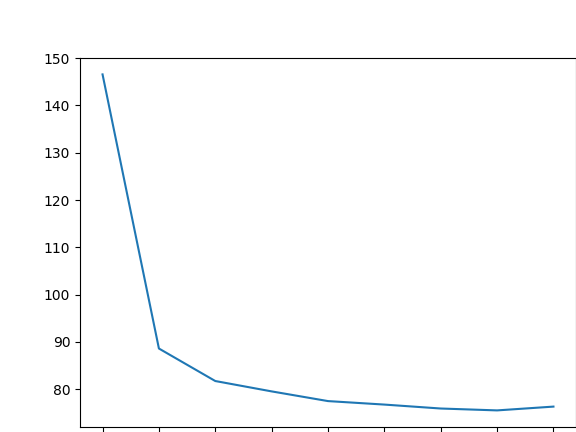

Loss: 76.32994842529297:   1%|        | 867/100000 [01:07<1:49:03, 15.15it/s]

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
from tqdm import tqdm

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

losses = []
with jax.experimental.maps.mesh(*model.mesh_def):
    steps = [t for t in range(0, 100000)]
    pbar = tqdm(steps)
    for t in pbar:
        x,y = ds.next_batch()
        loss, state = model.train(state, x,y)
        if t % 100 == 0:
            pbar.set_description(f"Loss: {loss.mean()}")
            losses.append(loss.mean())
            ax.clear()
            ax.plot(steps[:len(losses)], losses)
            fig.canvas.draw()

In [23]:
# Non auto-regressive sampling (works faster so you can see if it broadly making sense after 15 minutes)
with jax.experimental.maps.mesh(*model.mesh_def):
    y_pred = model.forward(state['params'], x)
    y_pred_logit = jnp.argmax(y_pred, -1)
    
    for i in range(0,100):
    print(''.join([ds.itos[c] for c in list(y_pred_logit[i])]))
    print('--------------------------')

# Minimal example explaining the loss implementation

In [179]:
# A test  explaining how the loss function works in simpler terms
logit = jnp.array([[-0.3,1,0.1], [0.1, 2, 0.4]])
target = jnp.array([[1,0,0], [0,0,1]])

def loss(logit, target):
    '''
    An explainer loss function before we show the full one
    '''
    # numerically stabilise logits
    stable_logit = logit - logit.max(-1, keepdims=True)
    # zero out any entries in the logit which don't correspond to the true label
    predicted_logit = jnp.multiply(target, stable_logit)
    # sum up the logit
    log_sum_exp = jnp.log(jnp.exp(stable_logit).sum(axis=-1))
    # subtract the summed logit from the summed 'predicted_logit'
    # Any entry but the correct one is 0 in 'predicted logit' - and due to the max used for stabilisation
    # the entry of the highest index will be 0. Therefore, the subtraction of the two will draw the highest index to the correct one.
    # By only working with sums when we are using the sharded version we minimise communication.
    loss = log_sum_exp - predicted_logit.sum(axis=-1)
    # And it allows for a really elegant way of calculating accuracy!
    return loss.sum()
    
for i in range(0,10):
    print(jnp.multiply(target, logit - logit.max(-1, keepdims=True)))
    l, grad_wrt_logit  =  value_and_grad(loss)(logit, target)
    logit -= 1 * grad_wrt_logit
    print(l)
    

[[-1.3  0.  -0. ]
 [-0.   0.  -1.6]]
3.719463
[[ 0.         -0.         -0.        ]
 [-0.          0.         -0.00945294]]
1.6977012
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.8638048
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.5450409
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.39282578
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.30563444
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.24965373
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.21083269
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.18234465
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.16059524


# Count model parameters

In [22]:
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten
import numpy as np


tot = 0
for j in state['params']:
    for k in state['params'][j]:
        shape = list(state['params'][j][k].shape)
        s = 1
        for f in shape:
            s *= f
        tot += s
        
print(tot)


340184130
